![](https://aif-s3.aif.ru/images/012/877/eb2fb6f7ad3828b8ea45baa590a10c1d.jpg)

<div style="border-radius:10px; border:#6B8BA0 solid; padding: 15px; background-color: #F2EADF; font-size:100%; text-align:left">

<h3 align="left"><font color='#6B8BA0'>👀 Table of Contents: </font></h3>
    
* [Importing Libraries](#1)
* [Loading Datasets](#2)
* [EDA](#3) & [Features](#3.1)
    * [Survived](#3.2)    
    * [PClass](#3.3)
    * [Sex](#3.4)
    * [Age](#3.5)    
    * [SibSp](#3.6)
    * [Parch](#3.7)
    * [Ticket](#3.8)    
    * [Fare](#3.9)
    * [Cabin](#3.10)    
    * [Embarked](#3.11)
* [Preprocessing](#4)
* [Training and Evaluation](#5) 
* [Submission](#6)

<a id="1"></a>
## 💻 Import dependencies

In [1]:
%%time

import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from colorama import Fore, Style
def colorize(text: str, color=Fore.MAGENTA, style=Style.BRIGHT):
    print(style+color+text+Style.RESET_ALL)
    
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

CPU times: user 1.16 s, sys: 416 ms, total: 1.58 s
Wall time: 2.3 s


<a id="2"></a>
## 📝 Loading datasets

In [2]:
%%time
df_train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col=0)
df_test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col=0)

CPU times: user 17.6 ms, sys: 1.94 ms, total: 19.5 ms
Wall time: 45 ms


In [3]:
df_train.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
df_test.head(1)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


#### Datasets loaded successfully!

<a id="3"></a>
## 📈 EDA

In [5]:
%%time
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
CPU times: user 9.68 ms, sys: 1.1 ms, total: 10.8 ms
Wall time: 16.8 ms


CPU times: user 365 ms, sys: 155 ms, total: 519 ms
Wall time: 293 ms


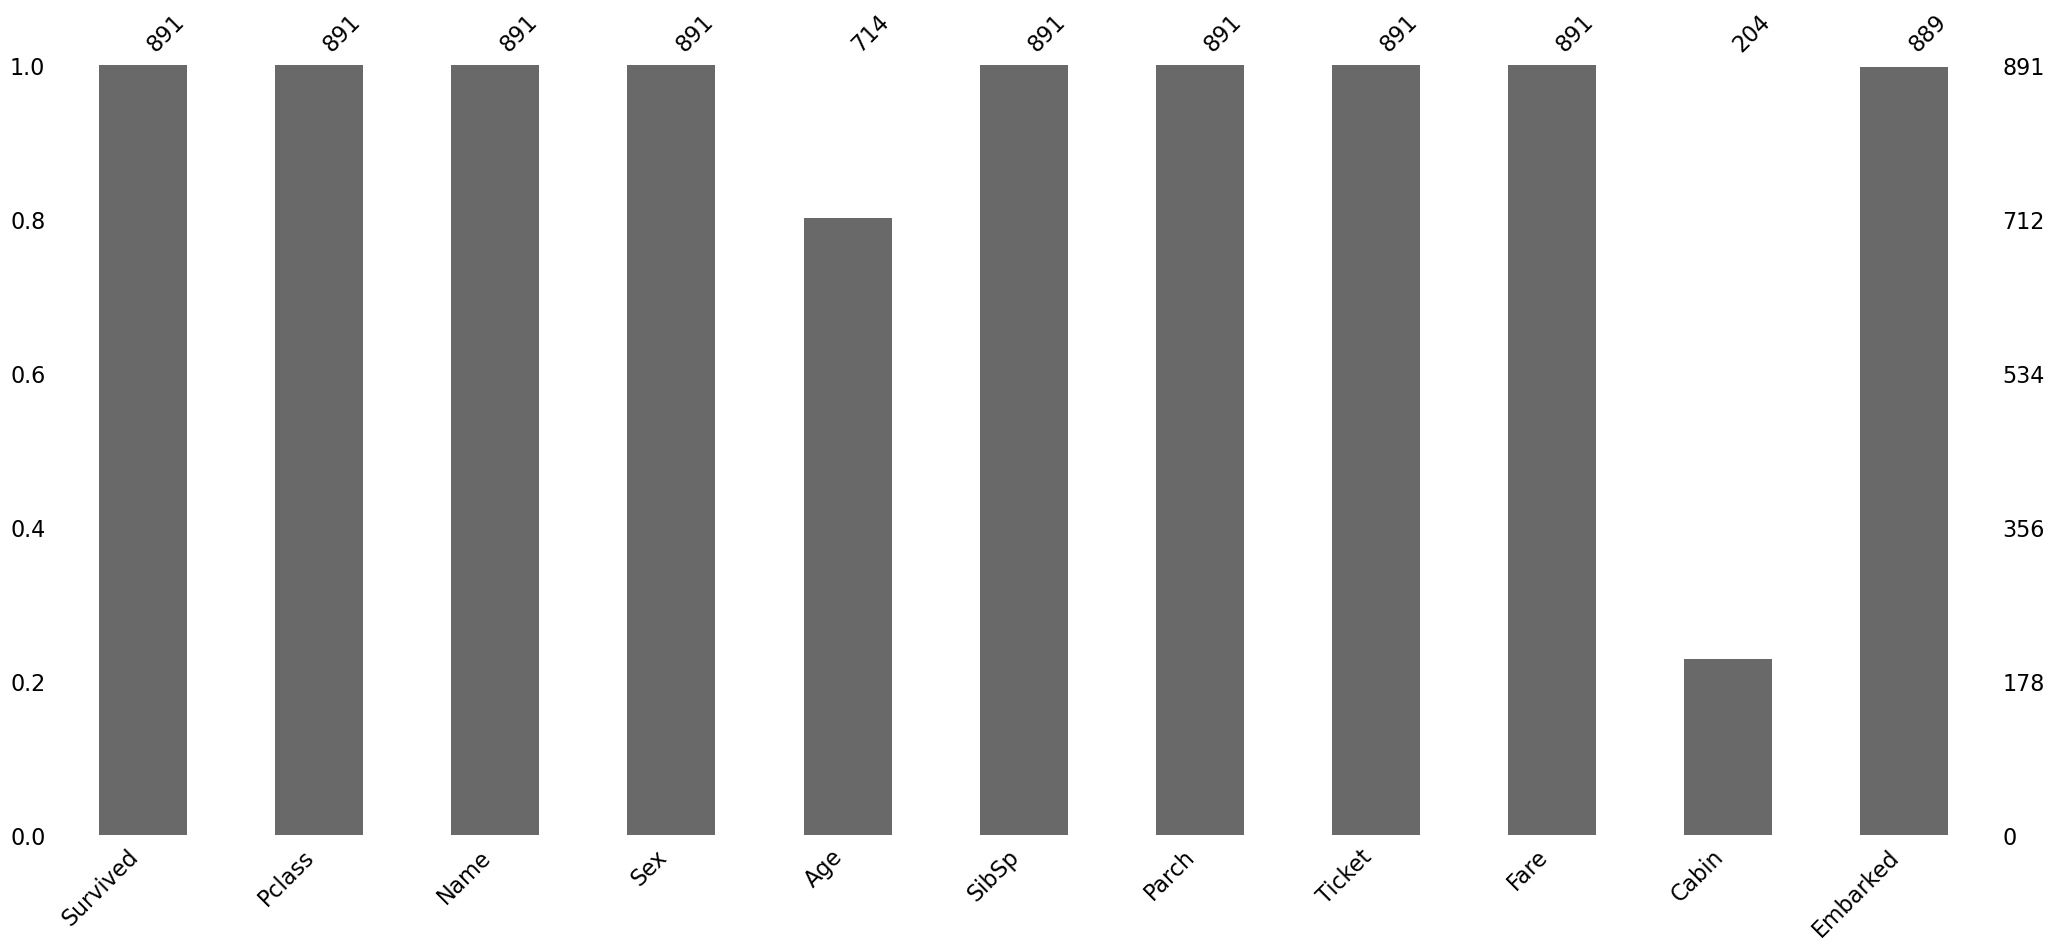

In [6]:
%%time
msno.bar(df_train);

CPU times: user 117 ms, sys: 43.1 ms, total: 160 ms
Wall time: 98.4 ms


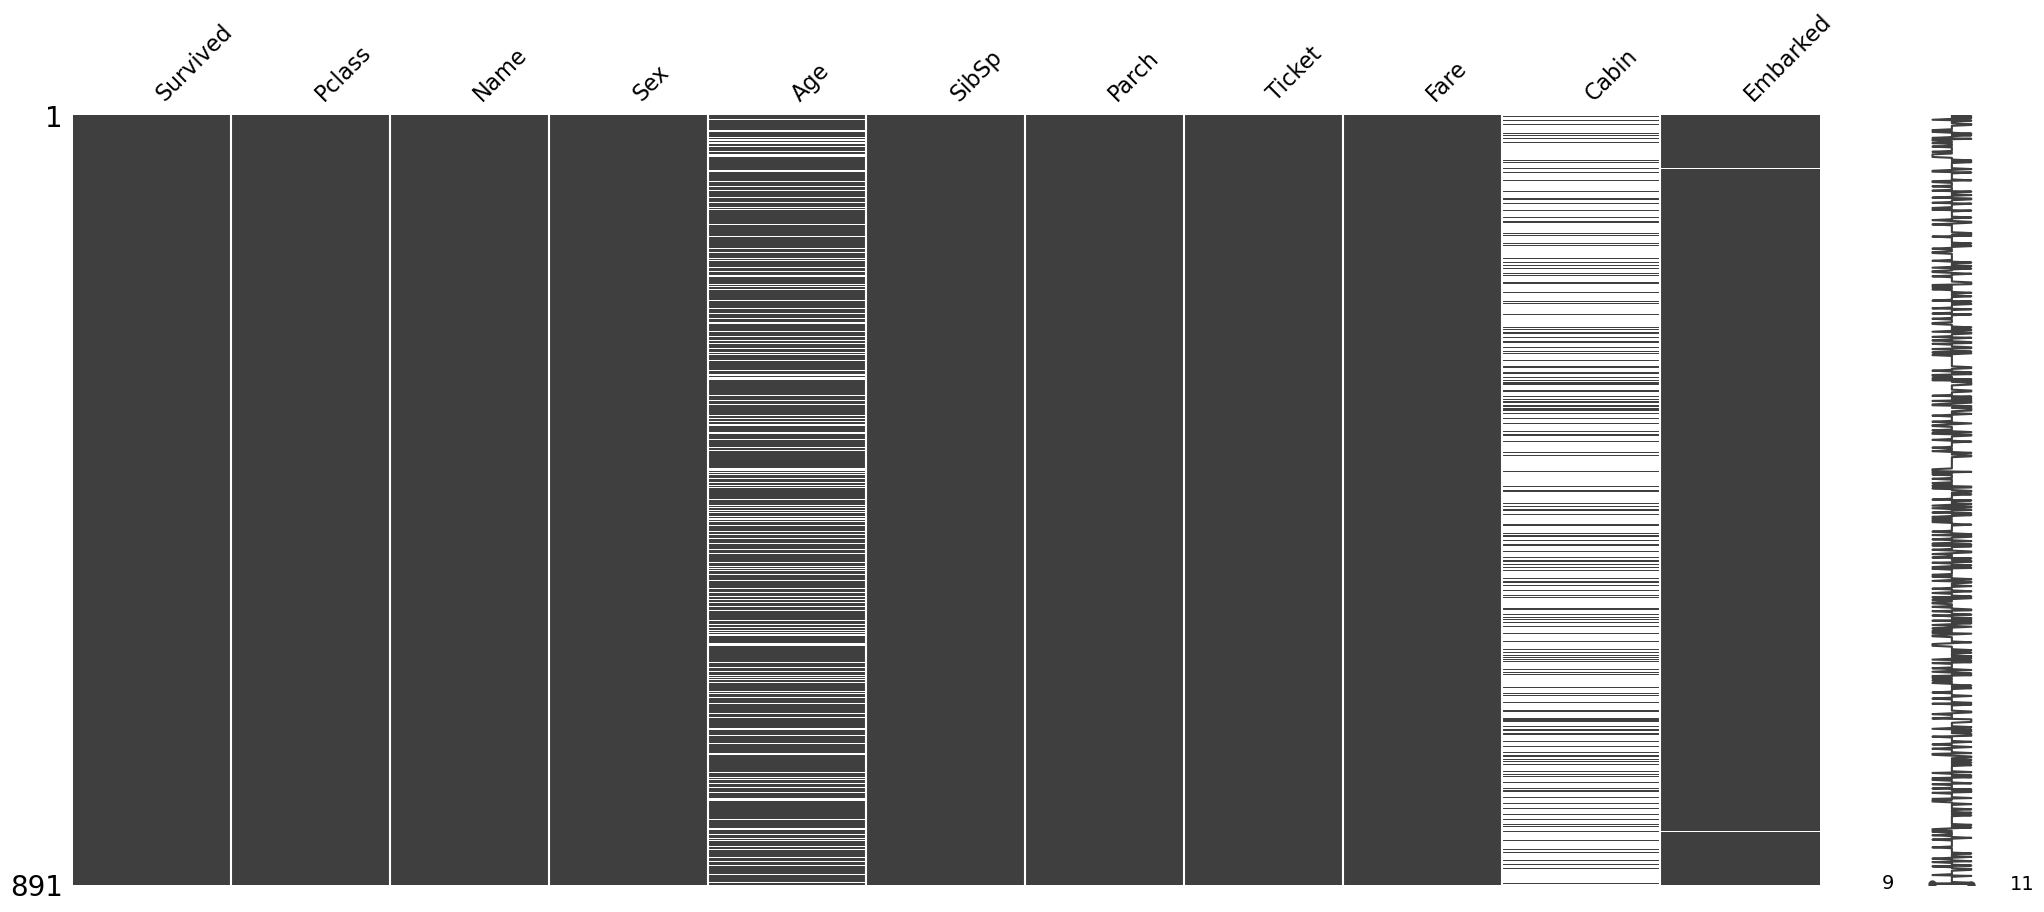

In [7]:
%%time
msno.matrix(df_train);

In [8]:
%%time
df_train.describe().T

CPU times: user 20.4 ms, sys: 93 µs, total: 20.5 ms
Wall time: 21.5 ms


,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [9]:
categorical_cols = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numerical_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
%%time
for num_col in numerical_cols:
    colorize(f'{num_col}: {stats.mode(df_train[num_col], nan_policy="omit")}')

Survived: ModeResult(mode=array([0]), count=array([549]))
Pclass: ModeResult(mode=array([3]), count=array([491]))
Age: ModeResult(mode=array([24.]), count=array([30.]))
SibSp: ModeResult(mode=array([0]), count=array([608]))
Parch: ModeResult(mode=array([0]), count=array([678]))
Fare: ModeResult(mode=array([8.05]), count=array([43]))
CPU times: user 5.82 ms, sys: 1e+03 ns, total: 5.82 ms
Wall time: 5.55 ms


#### High correlation between features means more noise and might be distracting. Let's use the heatmap to find out correlations between features

CPU times: user 306 ms, sys: 139 ms, total: 445 ms
Wall time: 205 ms


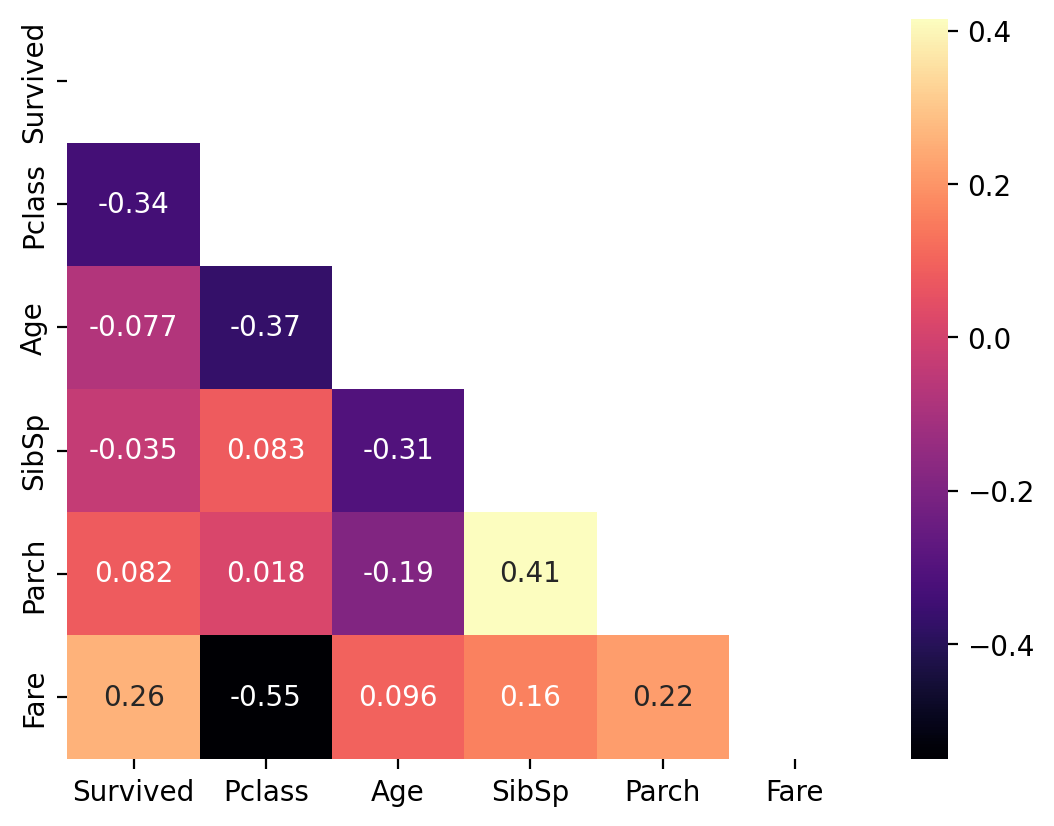

In [11]:
%%time
plt.figure(dpi=200)
mask = np.triu(df_train.corr())
sns.heatmap(df_train.corr(), annot=True, mask=mask, cmap='magma');

#### The highest absolute correlation is between Fare and Pclass, which is fair. Still, let's keep them both for the analysis and further training as long as it's lower than 0.6-0.7 and can possibly do more good than harm

In [12]:
%%time
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
CPU times: user 8.51 ms, sys: 893 µs, total: 9.4 ms
Wall time: 9.19 ms


CPU times: user 300 ms, sys: 144 ms, total: 444 ms
Wall time: 200 ms


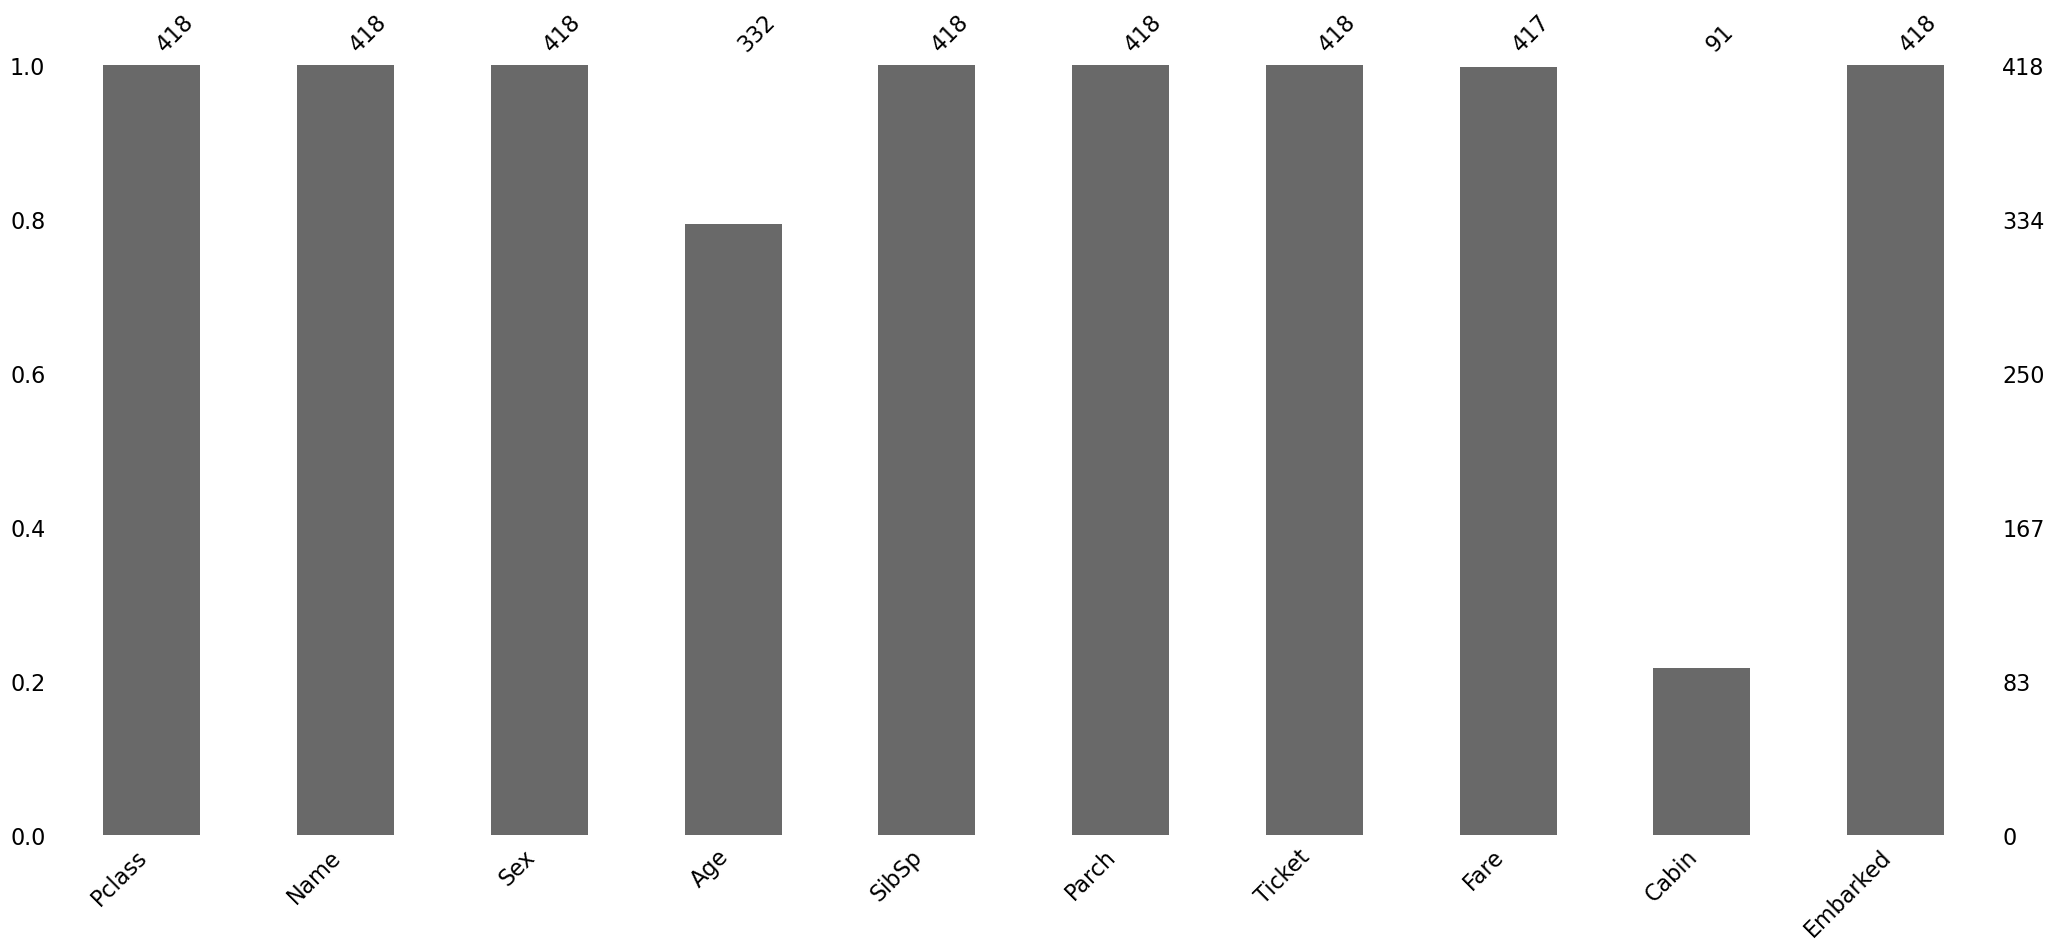

In [13]:
%%time
msno.bar(df_test);

CPU times: user 114 ms, sys: 25 ms, total: 139 ms
Wall time: 88.5 ms


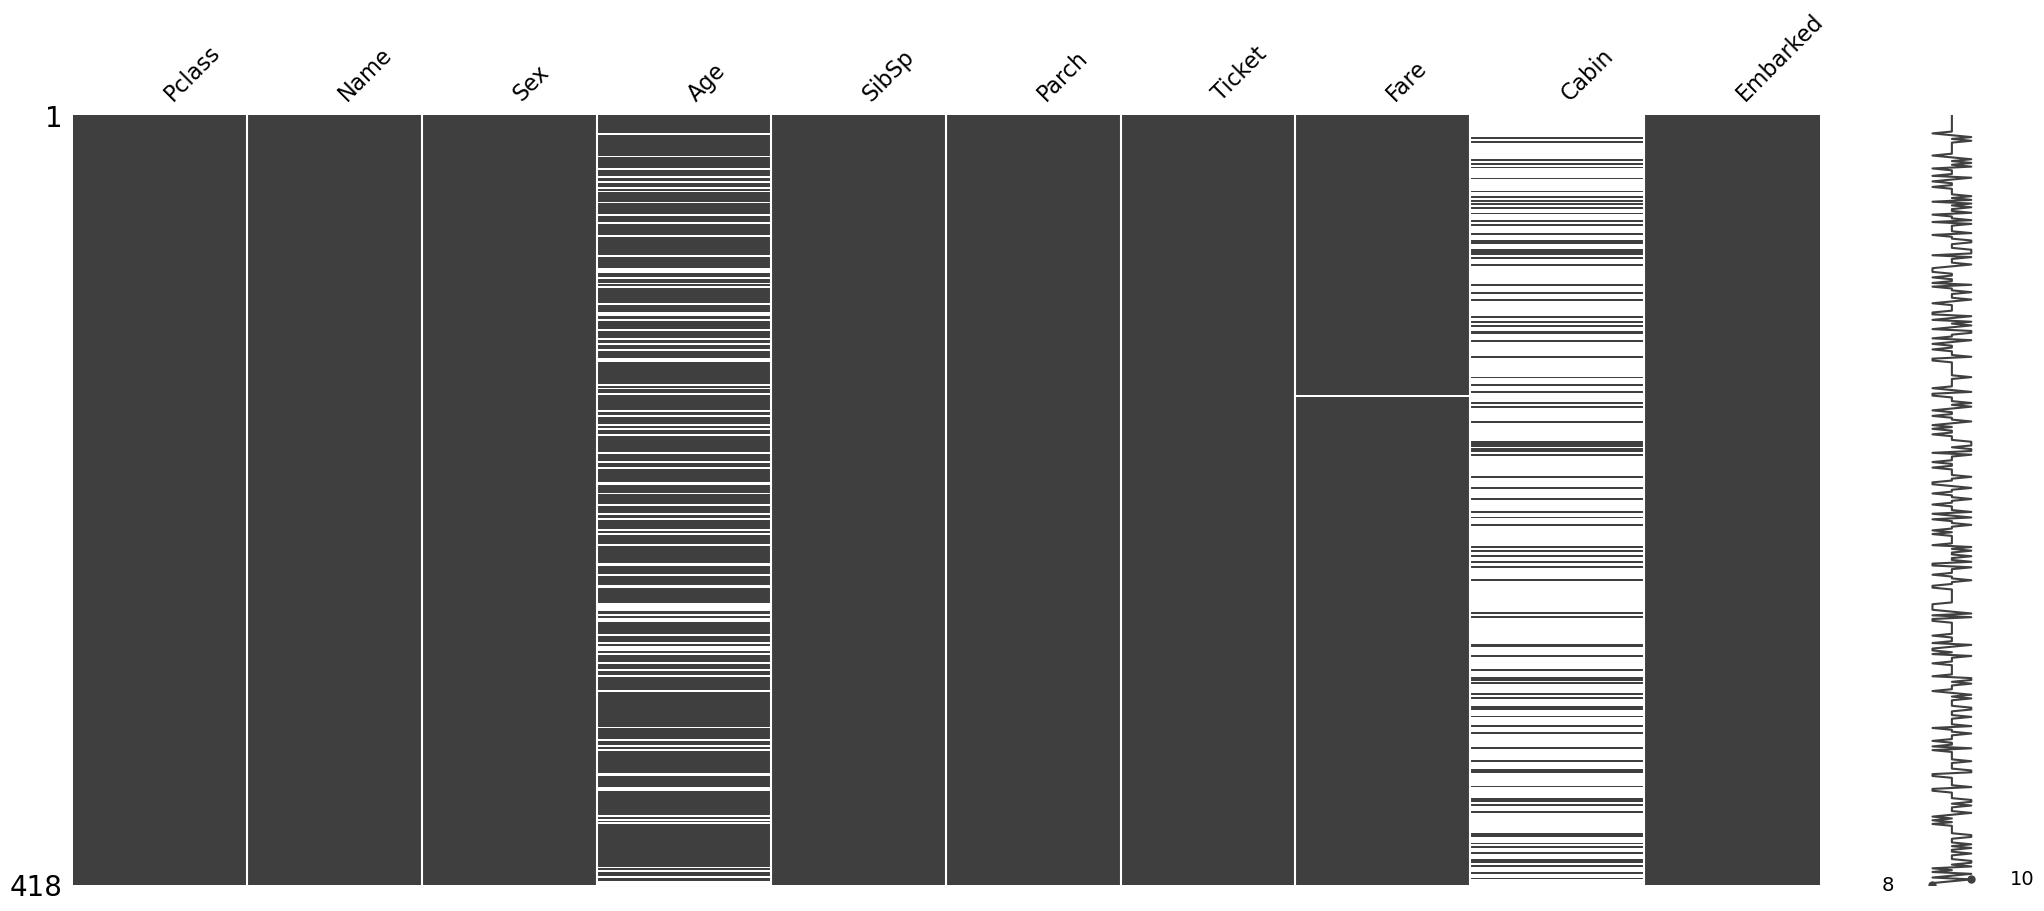

In [14]:
%%time
msno.matrix(df_test);

In [15]:
%%time
df_test.describe().T

CPU times: user 16.8 ms, sys: 1.19 ms, total: 18 ms
Wall time: 17.4 ms


,count,mean,std,min,25%,50%,75%,max
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.0,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.0,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.0,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292


<a id="3.1"></a>
+ # Features

<a id="3.2"></a>
> ## 1️⃣ Survived (0 = No, 1 = Yes)

CPU times: user 206 ms, sys: 4.08 ms, total: 210 ms
Wall time: 209 ms


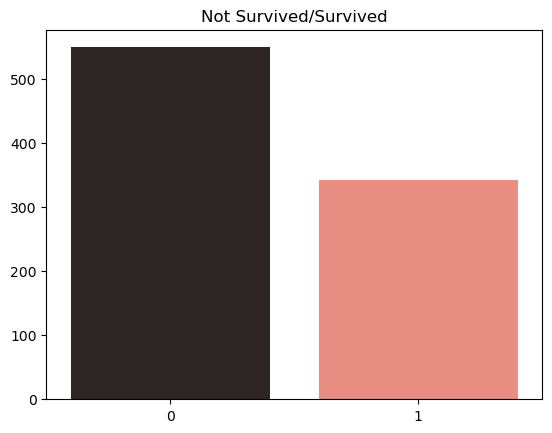

In [16]:
%%time
fig, ax = plt.subplots()
sns.countplot(x=df_train.Survived, palette='dark:salmon');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('Not Survived/Survived');

<a id="3.3"></a>
> ## 2️⃣ PClass (A proxy for socio-economic status)

In [17]:
%%time
colorize(f'{df_train.Pclass.value_counts()}')

3    491
1    216
2    184
Name: Pclass, dtype: int64
CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.52 ms


CPU times: user 33.7 ms, sys: 908 µs, total: 34.6 ms
Wall time: 34.6 ms


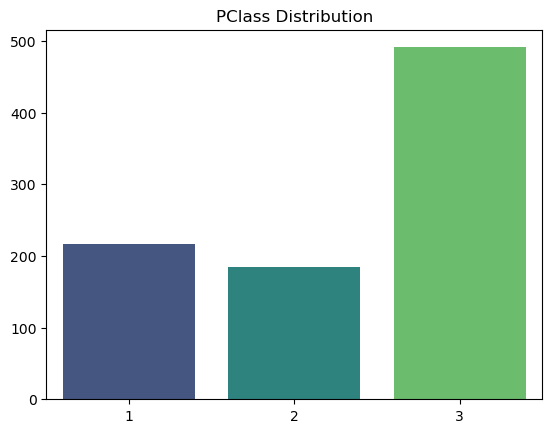

In [18]:
%%time
fig, ax = plt.subplots()
sns.countplot(x=df_train.Pclass, palette='viridis');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('PClass Distribution');

In [19]:
colorize(f'{len(df_train.Pclass)}')

891


In [20]:
stats.chisquare([len(df_train.Pclass.loc[df_train.Pclass==1]),
                 len(df_train.Pclass.loc[df_train.Pclass==2]),
                 len(df_train.Pclass.loc[df_train.Pclass==3])], [222, 222, 447], ddof=2)

Power_divergenceResult(statistic=10.997762863534675, pvalue=nan)

<a id="3.4"></a>
> ## 3️⃣ Sex

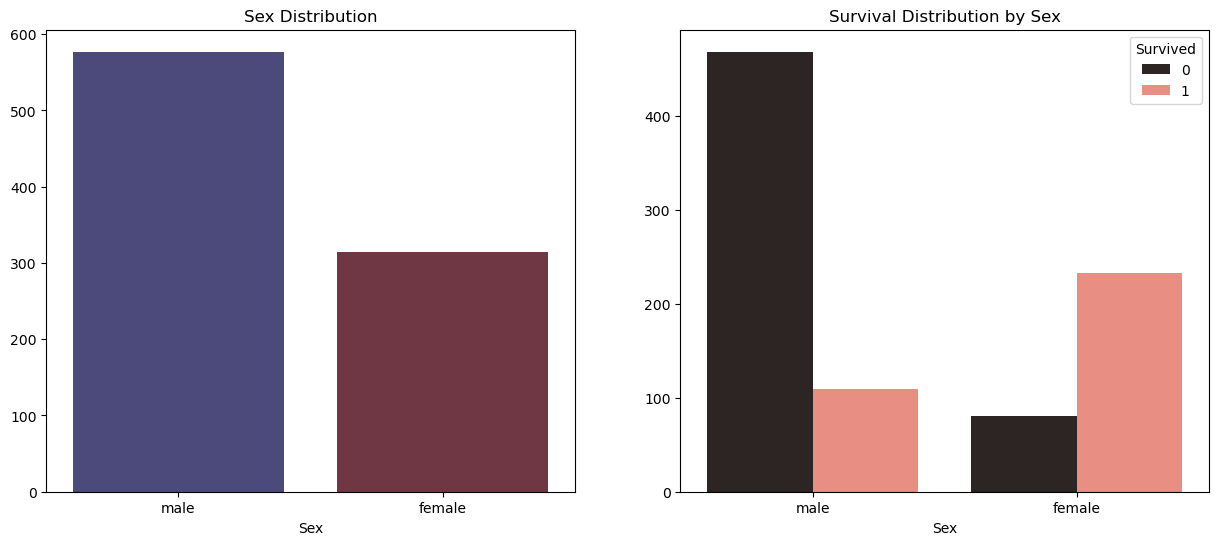

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x=df_train.Sex, ax=ax[0], palette='icefire');
ax[0].set_title('Sex Distribution');
ax[0].set_ylabel(None)
sns.countplot(x=df_train.Sex, hue=df_train.Survived, ax=ax[1], palette='dark:salmon');
ax[1].set_title('Survival Distribution by Sex')
ax[1].set_ylabel(None);

<a id="3.5"></a>
> ## 4️⃣ Age in years

CPU times: user 652 ms, sys: 467 ms, total: 1.12 s
Wall time: 390 ms


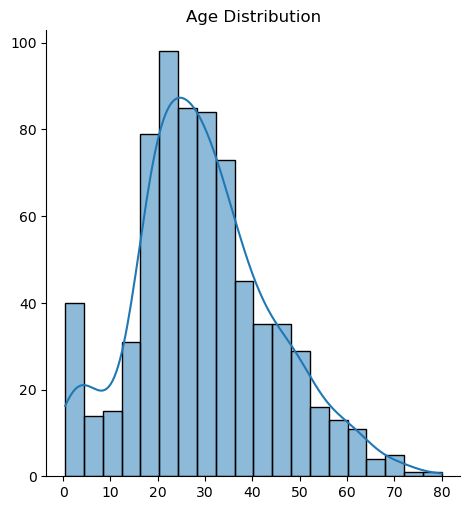

In [22]:
%%time
ax = sns.displot(df_train[['Age']], kde=True, legend=False);
plt.title('Age Distribution');
ax.set(ylabel=None);

In [23]:
colorize(f'NA values count: {df_train.Age.isna().sum()}')
colorize(f'Median age: {df_train.Age.median()}')
colorize(f'Mean age: {df_train.Age.mean()}')

NA values count: 177
Median age: 28.0
Mean age: 29.69911764705882


In [24]:
%%time
stats.normaltest(df_train['Age'], nan_policy='omit')

CPU times: user 5.48 ms, sys: 0 ns, total: 5.48 ms
Wall time: 8.07 ms


NormaltestResult(statistic=18.10503295208976, pvalue=0.00011709599657350744)

In [25]:
%%time
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)

CPU times: user 1.8 ms, sys: 1.21 ms, total: 3.01 ms
Wall time: 3.62 ms


<a id="3.6"></a>
> ## 5️⃣ SibSp (# of siblings / spouses aboard the Titanic)

In [26]:
colorize(f'{df_train.SibSp.value_counts()}')

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


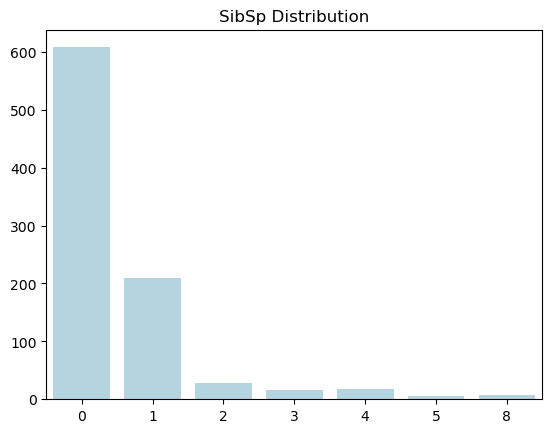

In [27]:
fig, ax = plt.subplots()
sns.countplot(x=sorted(df_train.SibSp.apply(lambda x: str(x))), color='lightblue');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('SibSp Distribution');

<a id="3.7"></a>
> ## 6️⃣ Parch (# of parents / children aboard the Titanic)

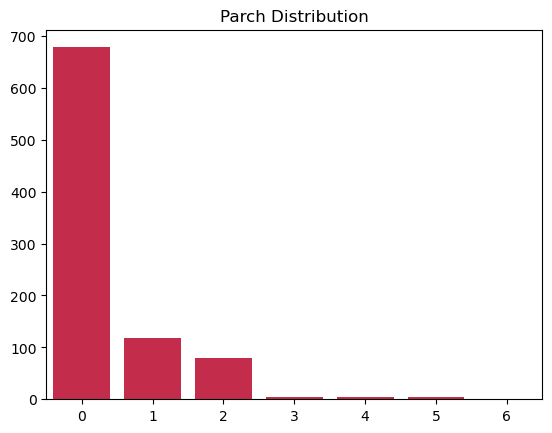

In [28]:
fig, ax = plt.subplots()
sns.countplot(x=df_train.Parch, color='crimson');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('Parch Distribution');

<a id="3.8"></a>
> ## 7️⃣ Ticket Preprocessing

In [29]:
df_train['Ticket_number'] = df_train['Ticket'].apply(lambda x: x.split(' '))
df_train['Ticket_number'] = df_train['Ticket_number'].apply(lambda x: x[-1] if 'LINE' not in x else pd.NA)

In [30]:
df_train['Ticket_number'] = pd.to_numeric(df_train['Ticket_number'])
colorize(f'Min Ticket Number: {int(df_train.Ticket_number.min())}')
colorize(f'Max Ticket Number: {int(df_train.Ticket_number.max())}')

Min Ticket Number: 3
Max Ticket Number: 3101317


<a id="3.9"></a>
> ## 8️⃣ Fare

In [31]:
colorize(f'Min Fare: {df_train.Fare.min()}')
colorize(f'Max Fare: {df_train.Fare.max()}')
colorize(f'Mean Fare: {df_train.Fare.mean()}')
colorize(f'Median Fare: {df_train.Fare.median()}')
colorize(f'{stats.mode(df_train.Fare)}')

Min Fare: 0.0
Max Fare: 512.3292
Mean Fare: 32.204207968574636
Median Fare: 14.4542
ModeResult(mode=array([8.05]), count=array([43]))


CPU times: user 258 ms, sys: 59.4 ms, total: 317 ms
Wall time: 211 ms


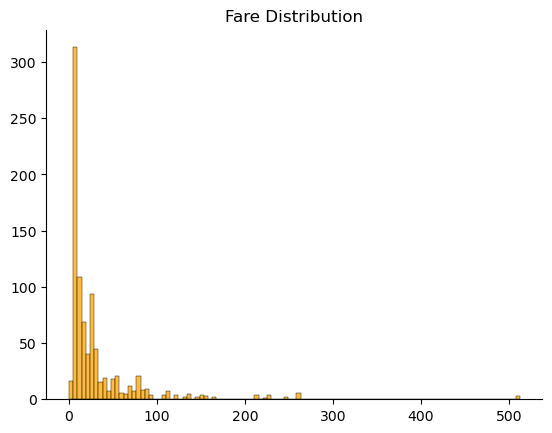

In [32]:
%%time
fig, ax = plt.subplots()
sns.histplot(df_train.Fare, color='orange');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('Fare Distribution');
sns.despine()

<a id="3.10"></a>
> ## 9️⃣ Cabin

In [33]:
df_train.Cabin.isna().sum()

687

#### As long as it is quite hard to figure out all the missing cabins and we will not include it into training process, let's better skip it for now

<a id="3.11"></a>
> ## 🔟 Embarked (Port of Embarkation)
> ## C = Cherbourg, Q = Queenstown, S = Southampton

In [34]:
%%time
colorize(f'{df_train.Embarked.value_counts()}')

S    644
C    168
Q     77
Name: Embarked, dtype: int64
CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.75 ms


CPU times: user 40.1 ms, sys: 2.97 ms, total: 43.1 ms
Wall time: 41.8 ms


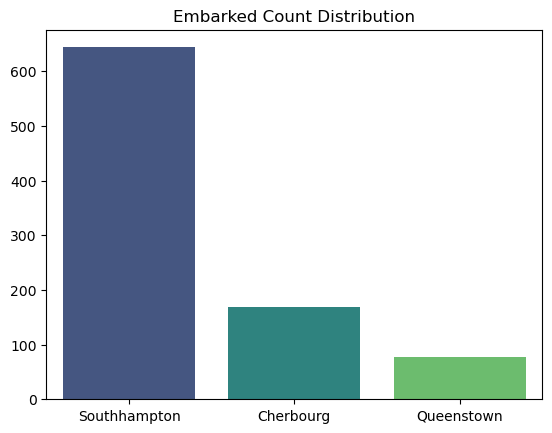

In [35]:
%%time
fig, ax = plt.subplots()
sns.countplot(x=df_train['Embarked'].map({'C': 'Cherbourg',
                                          'Q': 'Queenstown',
                                          'S': 'Southhampton'}), palette='viridis');
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title("Embarked Count Distribution");

In [36]:
df_train[df_train['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,113572.0
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,113572.0


In [37]:
sorted(df_train[df_train['Embarked'] == 'C']['Cabin'].dropna().unique())

['A10',
 'A16',
 'A20',
 'A26',
 'A31',
 'A5',
 'A7',
 'B101',
 'B18',
 'B30',
 'B35',
 'B37',
 'B39',
 'B4',
 'B41',
 'B49',
 'B50',
 'B51 B53 B55',
 'B57 B59 B63 B66',
 'B58 B60',
 'B78',
 'B80',
 'B82 B84',
 'B86',
 'C111',
 'C118',
 'C148',
 'C32',
 'C45',
 'C47',
 'C49',
 'C50',
 'C54',
 'C62 C64',
 'C65',
 'C68',
 'C70',
 'C82',
 'C85',
 'C86',
 'C90',
 'C92',
 'D',
 'D10 D12',
 'D15',
 'D20',
 'D33',
 'D36',
 'D37',
 'D48',
 'D49',
 'E34',
 'E36',
 'E40',
 'E49',
 'E50',
 'F E69']

In [38]:
df_train[df_train['Cabin'] == 'B30']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number
PassengerId,,,,,,,,,,,,
55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,113509.0


#### Considering the fact that the fare is pretty high, and the closest cabin to B28 is B30, I can assume that the port of embarkation might be C (Cherbourg). Not necessarily true, it's just my assumption

In [39]:
df_train['Embarked'].fillna('C', inplace=True)

<a id="4"></a>
## ✨ Preprocessing Pipeline

In [40]:
%%time
# The same pipeline as before
def train_preprocess(df_train):
    df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
    df_train['Embarked'].fillna('C', inplace=True)
    df_train['Ticket_number'] = df_train['Ticket'].apply(lambda x: x.split(' '))
    df_train['Ticket_number'] = df_train['Ticket_number'].apply(lambda x: x[-1] if 'LINE' not in x else pd.NA)
    df_train['Ticket_number'] = pd.to_numeric(df_train['Ticket_number'])
    df_train['Ticket_number'].fillna(df_train['Ticket_number'].median(), inplace=True)
    return pd.get_dummies(df_train.drop(['Name', 'Ticket', 'Cabin', 
                                         'Ticket_number', 'SibSp', 'Parch'], axis=1))

# Pipeline for test dataframe
def test_preprocess(df_test):
    df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)
    df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
    df_test['Embarked'].fillna('C', inplace=True)
    df_test['Ticket_number'] = df_test['Ticket'].apply(lambda x: x.split(' '))
    df_test['Ticket_number'] = df_test['Ticket_number'].apply(lambda x: x[-1] if 'LINE' not in x else pd.NA)
    df_test['Ticket_number'] = pd.to_numeric(df_test['Ticket_number'])
    df_test['Ticket_number'].fillna(df_test['Ticket_number'].median(), inplace=True)
    return pd.get_dummies(df_test.drop(['Name', 'Ticket', 'Cabin', 'Ticket_number', 
                                        'SibSp', 'Parch'], axis=1))
df_train = train_preprocess(df_train)
df_test = test_preprocess(df_test)

CPU times: user 15.8 ms, sys: 746 µs, total: 16.6 ms
Wall time: 17.4 ms


In [41]:
%%time
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('Survived', axis=1),
                                                  df_train['Survived'], test_size=0.1,
                                                  random_state=42)

CPU times: user 5.14 ms, sys: 794 µs, total: 5.93 ms
Wall time: 5.45 ms


In [42]:
%%time
scaler = MinMaxScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(df_test)

CPU times: user 9.94 ms, sys: 0 ns, total: 9.94 ms
Wall time: 9.88 ms


<a id="5"></a>
## 🎓 Training & Evaluation

In [43]:
%%time
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

CPU times: user 8.96 ms, sys: 986 µs, total: 9.95 ms
Wall time: 9.97 ms


In [44]:
accuracy_score(y_pred, y_val)

0.8333333333333334

In [45]:
%%time
preds = model.predict(X_test)

CPU times: user 25.6 ms, sys: 879 µs, total: 26.5 ms
Wall time: 26.3 ms


<a id="6"></a>
## 📰 Submitting the results

In [46]:
%%time
df_sub = pd.DataFrame(preds, columns=['Survived'], index=range(892, 1310))
df_sub.index.rename('PassengerId', inplace=True)
df_sub.to_csv('submission.csv')

CPU times: user 6.54 ms, sys: 0 ns, total: 6.54 ms
Wall time: 7.37 ms
